In [1]:
import os
import sys
import torch
import time
import shutil
from torchvision.transforms import ToPILImage
from os.path import join

base_directory = "../"
sys.path.insert(0, base_directory)

output_base_dir = "./output/noise-tests/sd2-notebook/"
output_directory = join(output_base_dir, "autoencoder/")

try: 
    shutil.rmtree(output_directory)
except Exception as e:
    print(e, "\n", "Creating the path...")
    os.makedirs(output_directory, exist_ok=True)
else:
    os.makedirs(output_directory, exist_ok=True)

from stable_diffusion2.stable_diffusion import StableDiffusion
from stable_diffusion2.utils.model import *
from stable_diffusion2.utils.utils import SectionManager as section
from stable_diffusion2.utils.utils import *



to_pil = lambda image: ToPILImage()(torch.clamp((image + 1.0) / 2.0, min=0.0, max=1.0))
device = get_device()

[WinError 3] The system cannot find the path specified: './output/noise-tests/sd2-notebook/autoencoder/' 
 Creating the path...
INFO: Using CUDA device: NVIDIA GeForce RTX 3080 Ti


In [2]:
#initialize an empty stable diffusion class
stable_diffusion = StableDiffusion(device=device)
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 11086 MiB
Used: 1201 MiB


In [3]:
# initialize an empty latent diffusion model; it returns self.model
stable_diffusion.quick_initialize()
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 10630 MiB
Used: 1657 MiB


In [4]:
# the latent diffusion class has a method to load the autoencoder, since it is a submodel of it. it returns the autoencoder
stable_diffusion.model.load_autoencoder()
get_memory_status()

Autoencoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\autoencoder.ckpt
Total: 12287 MiB
Free: 10630 MiB
Used: 1657 MiB


In [5]:
# the autoencoder has a method to load the encoder, since it's one of its submodels. it returns the encoder
stable_diffusion.model.autoencoder.load_encoder()
get_memory_status()

Encoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\encoder.ckpt
Total: 12287 MiB
Free: 10484 MiB
Used: 1803 MiB


In [6]:
# since each method returns the thing it loads, we could, for convenience, one-line that out: intialize a latent diffusion model, then load the autoencoder, then load the encoder
stable_diffusion.quick_initialize().load_autoencoder().load_encoder()
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Autoencoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\autoencoder.ckpt
Encoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\encoder.ckpt
Total: 12287 MiB
Free: 10484 MiB
Used: 1803 MiB


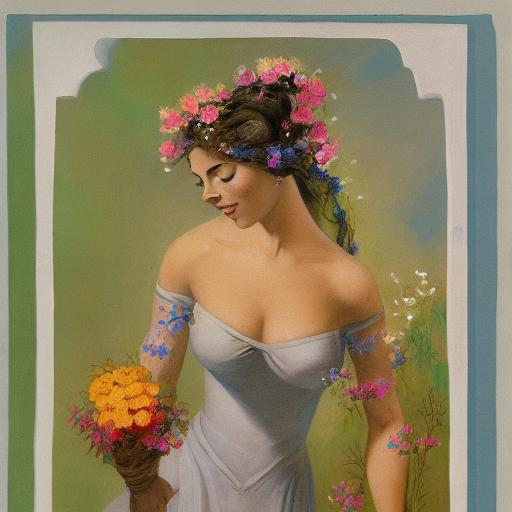

In [7]:
#load an image to test the encoder module
img = load_img("./input/test_img.jpg").to(device)
to_pil(img.squeeze(0))

In [8]:
#get the latent representation of the test image
encoded_img = stable_diffusion.encode(img)
get_memory_status()

Total: 12287 MiB
Free: 9136 MiB
Used: 3151 MiB


In [9]:
#check its shape
encoded_img.shape

torch.Size([1, 4, 64, 64])

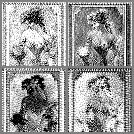

In [10]:
#show each dimension of the latent representation
grid = torchvision.utils.make_grid(encoded_img.permute(1, 0, 2, 3), nrow=2, normalize=False, range=(-1, 1), scale_each=True, pad_value=0)
dim_grid_image = to_pil(grid)
dim_grid_image.save(join(output_directory, f'encoding_dimensions_grid.png'))
dim_grid_image

In [11]:
#save it as a tensor
torch.save(encoded_img, join(output_base_dir, f'encoded_img_tensor.pt'))

In [12]:
del encoded_img
torch.cuda.empty_cache()
print(get_memory_status())

Total: 12287 MiB
Free: 9742 MiB
Used: 2545 MiB
None


In [13]:
#load it back
encoded_img = torch.load(join(output_base_dir, f'encoded_img_tensor.pt'))
torch.cuda.empty_cache()
get_memory_status()


Total: 12287 MiB
Free: 9740 MiB
Used: 2547 MiB


In [14]:
encoded_img.shape

torch.Size([1, 4, 64, 64])

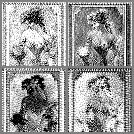

In [15]:
grid = torchvision.utils.make_grid(encoded_img.permute(1, 0, 2, 3), nrow=2, normalize=False, range=(-1, 1), scale_each=True, pad_value=0)
to_pil(grid)

In [16]:
del grid
torch.cuda.empty_cache()
get_memory_status()

Total: 12287 MiB
Free: 9740 MiB
Used: 2547 MiB


In [17]:
#unload the encoder submodel
stable_diffusion.model.autoencoder.unload_encoder()
torch.cuda.empty_cache()
get_memory_status()

Total: 12287 MiB
Free: 9866 MiB
Used: 2421 MiB


In [18]:
#load the decoder submodel
stable_diffusion.model.autoencoder.load_decoder()
torch.cuda.empty_cache()
get_memory_status()

Decoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\decoder.ckpt
Total: 12287 MiB
Free: 9800 MiB
Used: 2487 MiB


Total: 12287 MiB
Free: 9800 MiB
Used: 2487 MiB


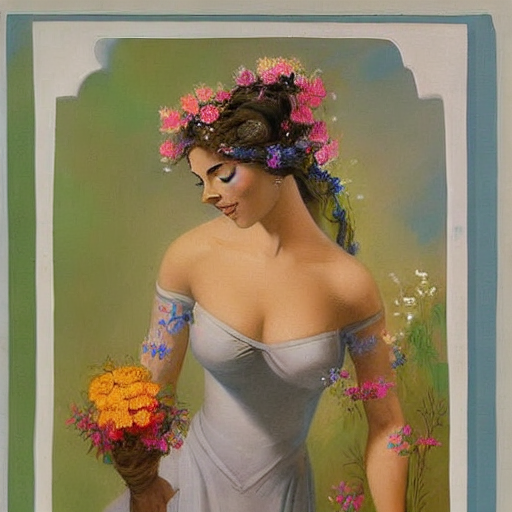

In [19]:
#decode the latent representation that we loaded from disk
decoded_img = stable_diffusion.decode(encoded_img)
save_images(decoded_img, join(output_directory, f'decoded_img.png'))
torch.cuda.empty_cache()
get_memory_status()
to_pil(decoded_img[0])

In [20]:
# initially loaded image isn't the same as the decoded image
torch.norm(img - decoded_img)

tensor(50.0789, device='cuda:0')

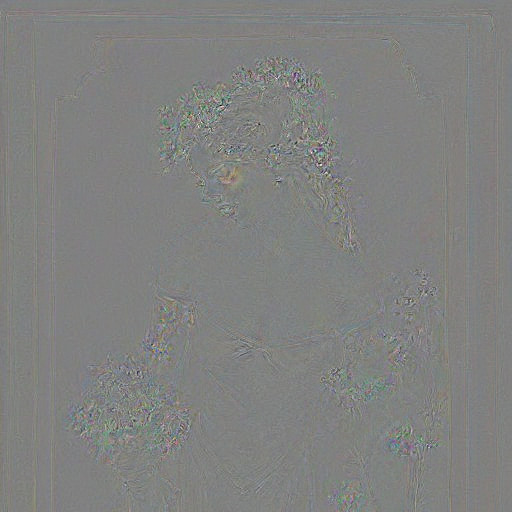

In [21]:
# plot the difference as an image
diff_img = to_pil((img - decoded_img).squeeze(0))
diff_img.save(join(output_directory, f'diff_img.png'))
diff_img